# COGS 108 - Final Project


# Group Members:

Name, PID, Project Contribution

- Kenny Wibowo - A12030884 - Data Cleaning, Data Parsing
- Varun Sujit - A11886049 - Written Sections and Organization, Data Visualization
- Angela Xu - A12413011 - 
- Aarjav Kothari - A91087718 -
- Joseph Thomas - A12008739 - Data Cleaning, Data Analysis

# Introduction and Background

For many on the internet, it seemed as though 2016 was a particularly awful year due to the deaths of many beloved actors, musician, and other celebrities. However, it may not actually be the case that 2016 had an unusually high number of celebrity deaths. Snopes examined the number of notable deaths reported by various news outlets in 2016 and in previous years and saw that while several news outlets reported more deaths in 2016 than in other years, the differences were not unusually high. This also does not necessarily mean than more celebrities are dying but rather it could be that news outlets are reporting more celebrity deaths in recent years. According to The Guardian, social media has contributed in amplifying emotional response after a celebrity death due to the speed at which news travels on these websites and apps as well as social media bringing people closer to the celebrities they adore. Time Magazine suggests that it is not the number of celebrity deaths that made 2016 unusual but rather the fact that many of the celebrities that passed away were particularly notable, which makes it seem like 2016 was worse than previous years.

The Telegraph also discusses some theories about why so many celebrities seemed to die in 2016. It could be that more people are dying in general or more people are being considered celebrities. It is also possible that many celebrities had unhealthy lifestyles that ultimately contributed to their untimely deaths. People’s perceptions could also have been affected due to celebrities dying on the same day or within days of each other. We also once again get the theory that social media amplifies celebrity deaths.

For our project, we will be examining the social media theory in particular. Since we get news spreads almost instantly through social media platforms and these platforms provide millions of people a place to express their emotions, it is quite plausible that social media has skewed people’s perceptions regarding the number of celebrity deaths.

In other words, our main question is this: What is the total number of significant celebrities that passed away in 2016, compared to other years? How has social media impacted our bias of noting these deaths? We propose that that although it may be true that a significant number of celebrities passed away in 2016, the introduction of modern media, especially through social mediums such as Facebook and Reddit, has caused a sense of “over sensationalization” that biased our judgement of how many celebrities passed away in 2016 compared to other years.

References: 1)https://www.snopes.com/2016/12/28/2016-the-deadliest-year-for-celebrities/ 2)http://www.telegraph.co.uk/men/thinking-man/why-are-so-many-celebrities-dying-in-2016/

# Data Description

For context of this project, we are considering every individual that is present in a category or list in https://en.wikipedia.org/wiki/Lists_of_celebrities as a celebrity. Our data is comprised of lists of celebrities, and their relevence via pytrends, an API that queries google trends (https://trends.google.com/trends/). As a result, we need to parse through every link in the list recursively, and extract the list of celebrities that are deceased. The html parsing is done by using BeautifulSoup. This data will then be stored in a JSON file which can easily be converted into a pandas dataframe for future analysis. The pytrends API, allows users to query google trends with a list of keywords. The popularity of each key word is then compared to the other, returning numerical values in proportion to the other. For example if one keyword has a value 100 and the other 50, this means that the former is twice as popular for that particular day/time. This means in order for our data to proportionally the same across multiple queries, each celebrity must be queried along with a constant keyword, one that has a preferably stable popularity.

## Data Cleaning/Pre-processing

The first step in our project is to import our dependencies

In [56]:
import pandas as pd
import requests
import bs4
from bs4 import BeautifulSoup
from urllib.parse import urlparse
from collections import deque
from pytrends.request import TrendReq
from datetime import datetime
import time
from collections import defaultdict
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import patsy
import statsmodels.api as sm
import scipy.stats as stats

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [87]:
import sys
!{sys.executable} -m pip install pytrends

You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


First, we will define a helper function that we will use to return the celebrity name and death date, along with any other features we would like to extract. 

If we pass in any page that isn't a wikipedia page of a deceased notable celebrity (as per our definition), the function will return `None`.

In [2]:
def get_death_date(soup):
    table_selector = soup.select('table.infobox.vcard')

    if table_selector:
        table = table_selector[0]
        
        # Important features we would like to handle specially
        name = table.find('span', class_='fn')
        born = table.find('span', class_='bday')
        died = table.find('span', class_='dday deathdate')
        
        # Only return if the person has a name, has born data, and died
        if name and born and died:
            data =  {'Name': name.text, 'Born': born.text, 'Died': died.text}
            
            # Extract other features that we would like to keep.
            rows = table.find_all('tr')
            for row in rows:
                header = row.find('th')
                datum = row.find('td')
                if header and datum and header.text not in data:
                    data[header.text.replace('\xa0', ' ').strip()] = datum.get_text(' ', strip=True)
                    
            return data
        
    return None

Then, we will recursively traverse the links through Breadth First Search and visit all Wikipedia links reachable from the 'List of Celebrities' page. 

In [3]:
# Breadth First Search traversal.

wikipedia_url = 'https://en.wikipedia.org'
starting_endpoint = '/wiki/Lists_of_celebrities'
click_limit = 2

# Dictionary of visited links
# 'url' -> number of clicks taken to get to link
links_visited = {starting_endpoint: 0} 
# Queue of links to visit
links_queue = deque()
links_queue.appendleft(starting_endpoint)

# Create a buffer of dataframes
data_buffer = deque()

# Debug info
num_visited = 0

# Find all links on the page that lead to another wikipedia page.
while links_queue:
    link = links_queue.pop()
    page = requests.get(wikipedia_url + link)
    soup = BeautifulSoup(page.content, 'html.parser')
    num_visited += 1
    
    # Debug info
    if links_visited[link] >= click_limit - 1:
        num_links = len(links_visited)
        num_deads = len(data_buffer)
        percentage = format(100.0*(float(num_visited)/num_links), '.2f')
        print((percentage + "% - " + str(len(links_queue)) + " left, " + str(num_deads) + " recorded.").ljust(60),  end='\r', flush=True)
    else:
        print("Loading initial pages...", end='\r', flush=True)
    
    # See if page is of deceased person - if so, get the data
    results = get_death_date(soup)
    
    # Append to dataframe buffer if we've found a match
    if results:
        data_buffer.append(pd.DataFrame([results]))
    
    # Break early on click limit or if page isn't a list
    if links_visited[link] == click_limit or ("List" not in link and "Category:" not in link):
        continue
    
    content = soup.find('div', id='content')
    
    # Continue BFS on links in the page
    if content:
        for candidate in content.findAll('a'):
            if 'href' in candidate.attrs:
                link_in_page = urlparse(candidate.attrs['href']).path
                                
                # Add to queue if it's a link we haven't seen before.
                if link_in_page not in links_visited and link_in_page.startswith('/wiki/') and 'File' not in link_in_page:
                    links_visited[link_in_page] = links_visited[link] + 1
                    links_queue.appendleft(link_in_page)

# Concatenate all of the buffer into the dataframe that holds our celebrity data
df_celebrities = pd.concat(data_buffer)

Since this takes such a long time, we will run this once and cache it into a JSON file. All subsequent operations will be run off of the loaded JSON file.

In [112]:
with open('celebrities.json', 'w') as file:
    file.write(df_celebrities.to_json(orient='records'))

NameError: name 'df_celebrities' is not defined

Now, we can read the file back in as the JSON in order to circumvent the crawling process for future usage.

In [120]:
df_celebrities = pd.read_json("celebrities.json", orient="records")

In [121]:
date_objects = []

base_date = datetime.strptime("2004-01-01", "%Y-%m-%d")

for date in df_celebrities["Died"]:
    date_objects.append(datetime.strptime(date, "%Y-%m-%d"))
df_celebrities["Died"] = date_objects


df_valid = df_celebrities[df_celebrities["Died"] >= base_date]

Since pytrends records begin in 2004, we will discard any deaths that happened before that. This leaves us with 846 celebrities that died from 2004-01-01 to present.

In [122]:
#Search word to compare it to
comparator = "Grand Canyon"

#Open the pytrends request
pytrends = TrendReq(hl='en-US', tz=360)

#Create a list for the new column in the table
trends = []
comparator_average_trends = []
trend_ratio = []

#Find the relative trend at time of death compared to comparator
#Comparator relative trend value taken from 2004-01-01
def relative_trend(name, died):
    #Enter the name for searching the trend
    kw_list = [comparator, name]
    #Get a dataframe of the relative trends
    e_catcher = 0
    while e_catcher == 0:
        try:
            pytrends.build_payload(kw_list, timeframe='all')
            df_py = pytrends.interest_over_time()
            e_catcher = 1
        except:
            time.sleep(3600)
    cv = df_py[comparator].tolist()
    comparator_avg = sum(cv)/float(len(cv))
    trend = df_py[(df_py.index.month == died.month) & (df_py.index.year == died.year)][name].iloc[0]
    trend_ratio = trend/comparator_avg
    return trend, comparator_avg, trend_ratio
    

#Loop through and find all the trends relative to grand canyon
counter = 0
for name, died in zip(df_valid["Name"], df_valid["Died"]):
    #Check if there are more than two parts to the name
    name_split = name.split(" ")
    name_split_len = len(name_split)
    shortened_name = name_split[0] + " " + name_split[name_split_len-1]
    if  name_split_len > 2:
        long_rt, cvl, trl = relative_trend(name,died)
        short_rt, cvs, trs = relative_trend(shortened_name,died)
        if long_rt > short_rt:
            trends.append(long_rt)
            comparator_average_trends.append(cvl)
            trend_ratio.append(trl)
        else:
            trends.append(short_rt)
            comparator_average_trends.append(cvs)
            trend_ratio.append(trs)
    else:
        trend, cv, tr = relative_trend(name,died)
        trends.append(trend)
        comparator_average_trends.append(cv)
        trend_ratio.append(tr)
    counter += 1
    print(("Celebrity trends parsed = " + str(counter)), end='\r', flush=True)
df_valid['Trends'] = trends
df_valid['Comp_Average'] = comparator_average_trends
df_valid['Trend_Ratio'] = trend_ratio

/Users/joseph/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/joseph/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/joseph/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

In [123]:
with open('valid.json', 'w') as file:
    file.write(df_valid.to_json(orient='records'))

# Data Analysis/Data Visualization

In [34]:
df_valid = pd.read_json("valid.json", orient="records")

In [35]:
df_valid["Died"] = pd.to_datetime(df_valid['Died'], unit="ms")
#Get rid of 2018, since its not a complete year
df_valid = df_valid[df_valid["Died"] < datetime.strptime("2018-01-01", "%Y-%m-%d")]

In [36]:
#Count the number of deaths per year
deaths_per_year = defaultdict(int)
for row in df_valid["Died"]:
    deaths_per_year[row.year] += 1
deaths_sorted = OrderedDict(sorted(deaths_per_year.items()))

In [37]:
#Print number of deaths per year sorted by deaths
for key,value in deaths_sorted.items():
    print( "Deaths in " + str(key) + " = " + str(value))

Deaths in 2004 = 56
Deaths in 2005 = 48
Deaths in 2006 = 56
Deaths in 2007 = 48
Deaths in 2008 = 58
Deaths in 2009 = 45
Deaths in 2010 = 62
Deaths in 2011 = 61
Deaths in 2012 = 58
Deaths in 2013 = 61
Deaths in 2014 = 60
Deaths in 2015 = 63
Deaths in 2016 = 78
Deaths in 2017 = 77


In [38]:
#Find the trends per year
trends_per_year = defaultdict(list)
for key,value in deaths_per_year.items():
    df = df_valid[(df_valid.Died >= datetime.strptime(str(key), "%Y")) & (df_valid.Died < datetime.strptime(str(key + 1), "%Y"))]
    trends_per_year[key] = df.Trends.tolist()

In [39]:
#Find the sum of trends and average of trends per year
trends_per_year_sum = defaultdict(int)
trends_per_year_avg = defaultdict(float)

for key,value in trends_per_year.items():
    tr = trends_per_year[key]
    trends_per_year_sum[key] = sum(tr)
    trends_per_year_avg[key] = sum(tr)/ float(len(tr))

In [40]:
trends_per_year_sum_ord = OrderedDict(sorted(trends_per_year_sum.items()))
trends_per_year_avg_ord = OrderedDict(sorted(trends_per_year_avg.items()))

In [41]:
for key,value in trends_per_year_sum_ord.items():
    print( "Trend sum in " + str(key) + " = " + str(value))

Trend sum in 2004 = 788
Trend sum in 2005 = 551
Trend sum in 2006 = 375
Trend sum in 2007 = 282
Trend sum in 2008 = 713
Trend sum in 2009 = 738
Trend sum in 2010 = 1078
Trend sum in 2011 = 865
Trend sum in 2012 = 1425
Trend sum in 2013 = 662
Trend sum in 2014 = 1217
Trend sum in 2015 = 1052
Trend sum in 2016 = 1584
Trend sum in 2017 = 1333


In [42]:
for key,value in trends_per_year_avg_ord.items():
    print( "Trend avg in " + str(key) + " = " + str(value))

Trend avg in 2004 = 14.071428571428571
Trend avg in 2005 = 11.479166666666666
Trend avg in 2006 = 6.696428571428571
Trend avg in 2007 = 5.875
Trend avg in 2008 = 12.293103448275861
Trend avg in 2009 = 16.4
Trend avg in 2010 = 17.387096774193548
Trend avg in 2011 = 14.180327868852459
Trend avg in 2012 = 24.56896551724138
Trend avg in 2013 = 10.852459016393443
Trend avg in 2014 = 20.283333333333335
Trend avg in 2015 = 16.6984126984127
Trend avg in 2016 = 20.307692307692307
Trend avg in 2017 = 17.31168831168831


In [43]:
for key,value in trends_per_year_avg_ord.items():
    print( "Deaths, Trend sum, Trend average in " + str(key) + " = " + str(deaths_per_year[key]) + ", " + str(trends_per_year_sum[key]) + ", " + str(trends_per_year_avg[key]))

Deaths, Trend sum, Trend average in 2004 = 56, 788, 14.071428571428571
Deaths, Trend sum, Trend average in 2005 = 48, 551, 11.479166666666666
Deaths, Trend sum, Trend average in 2006 = 56, 375, 6.696428571428571
Deaths, Trend sum, Trend average in 2007 = 48, 282, 5.875
Deaths, Trend sum, Trend average in 2008 = 58, 713, 12.293103448275861
Deaths, Trend sum, Trend average in 2009 = 45, 738, 16.4
Deaths, Trend sum, Trend average in 2010 = 62, 1078, 17.387096774193548
Deaths, Trend sum, Trend average in 2011 = 61, 865, 14.180327868852459
Deaths, Trend sum, Trend average in 2012 = 58, 1425, 24.56896551724138
Deaths, Trend sum, Trend average in 2013 = 61, 662, 10.852459016393443
Deaths, Trend sum, Trend average in 2014 = 60, 1217, 20.283333333333335
Deaths, Trend sum, Trend average in 2015 = 63, 1052, 16.6984126984127
Deaths, Trend sum, Trend average in 2016 = 78, 1584, 20.307692307692307
Deaths, Trend sum, Trend average in 2017 = 77, 1333, 17.31168831168831


In [44]:
#Count the number of positive trend deaths per year
positive_deaths_per_year = defaultdict(int)
for death,trend in zip(df_valid["Died"],df_valid["Trends"]):
    if trend >= 1:
        positive_deaths_per_year[death.year] += 1
positive_deaths_sorted = OrderedDict(sorted(positive_deaths_per_year.items()))

In [45]:
for key,value in positive_deaths_sorted.items():
    print( "Trend Ratios in " + str(key) + " greater than 1 = " + str(value))

Trend Ratios in 2004 greater than 1 = 38
Trend Ratios in 2005 greater than 1 = 39
Trend Ratios in 2006 greater than 1 = 36
Trend Ratios in 2007 greater than 1 = 35
Trend Ratios in 2008 greater than 1 = 42
Trend Ratios in 2009 greater than 1 = 31
Trend Ratios in 2010 greater than 1 = 43
Trend Ratios in 2011 greater than 1 = 46
Trend Ratios in 2012 greater than 1 = 50
Trend Ratios in 2013 greater than 1 = 42
Trend Ratios in 2014 greater than 1 = 38
Trend Ratios in 2015 greater than 1 = 41
Trend Ratios in 2016 greater than 1 = 57
Trend Ratios in 2017 greater than 1 = 57


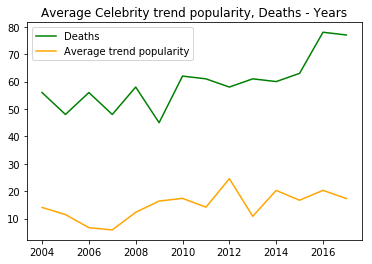

In [84]:
years = list(deaths_sorted.keys())
deaths = list(deaths_sorted.values())
trend_data = list(trends_per_year_avg_ord.values())

plt.plot(years, deaths, color='g', label='Deaths')
plt.plot(years, trend_data, color='orange', label='Average trend popularity')
plt.title('Average Celebrity trend popularity, Deaths - Years')
plt.legend()
plt.show()

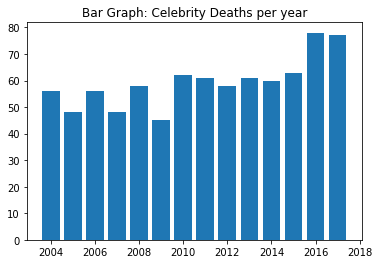

In [87]:
plt.bar(years,deaths)
plt.title('Bar Graph: Celebrity Deaths per year')
plt.show()

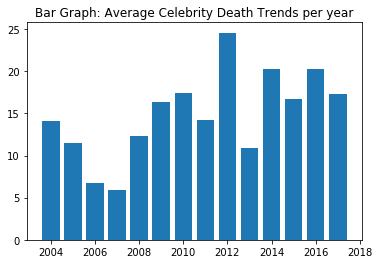

In [86]:
plt.bar(years,trend_data)
plt.title('Bar Graph: Average Celebrity Death Trends per year')
plt.show()

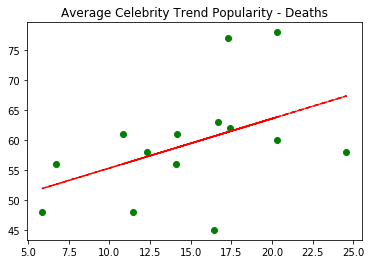

In [82]:
plt.scatter(trend_data, deaths, color='g')
z = np.polyfit(trend_data, deaths, 1)
p = np.poly1d(z)
plt.plot(trend_data,p(trend_data),"r--")
plt.title('Average Celebrity Trend Popularity - Deaths')
plt.show()

In [64]:
dictionary = {'trends': trend_data, 'deaths': deaths}
regressionframe = pd.DataFrame(data=dictionary)
outcome_1, predictors_1 = patsy.dmatrices('deaths ~ trends', regressionframe)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 deaths   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     3.111
Date:                Wed, 21 Mar 2018   Prob (F-statistic):              0.103
Time:                        20:18:00   Log-Likelihood:                -49.263
No. Observations:                  14   AIC:                             102.5
Df Residuals:                      12   BIC:                             103.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     47.0512      7.364      6.389      0.0

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


# Privacy/Ethics Considerations

We have permission to utilize these datasets as most of our data is from open sourced websites and are open to public use. Due to celebrities being public figures, it is unlikely that we would encounter any additional privacy issues due the data being dependent on social media trends and their deaths. Because we are allowing wikipedia to define our definition of a celebrity, It is possible that what constitutes a “celebrity” might vary from person to person. This can potentially cause our data to become more confusing as some of the deaths contributing to the dataset might not lead to substantial social media trends compared to other deaths. This could skew that data in that the deaths in a year were notable, but not well-known to American media and public.

# Conclusions and Discussion

From our data analyisis we found that there was a positive weak correlation between social media trends and deaths. The year 2016 had a larger number of popular celebrity deaths and a larger overall number of celebrity deaths from 2004 onwards. This leads us to believe that our initial hypothesis was incorrect and that the wide usage of social media and the internet was not the reason for believing that 2016 had more celebrity deaths than in the past. This contributes to the possiblity that perhaps social media and the internet can aid in public awareness of noteworthy statistical occurences.

As a way to further pursue this topic, analysis could be also be applied in separate regions throughout 2016 to determine internet popularity rather than globally. This could lead to more nuance in the number of celebrity deaths with positive social media trends. The large number of celebrity deaths in 2016 could possibly be because of the number of popular figures born 60 to 80 years ago, in which lifespans coincide with the digital age today, further analysis would also look at birth years as well, to determine if there is a notable trend.